# Notebook I - Climate Regime
<hr>
This module performs climate data analysis and compiling general agro-climatic indicators. These general agro-climatic indicators summarize climatic profiles in the study area for each grid. The key input data for this module is the climatic data, and the geographical and terrain data.

Prepared by Geoinformatics Center, AIT
<hr>


### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ. You will need to have the following packages installed on your own machine:
- numpy
- xarray
- rioxarray
- gdal
- scipy
- psutil
- os
- sys
- matplotlib
- colorcet

optional if you are planning to use parallel (fast) computing (by setting parallel=True later in this notebook):
- dask

If working on your own PC/machine, these additional installations will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal

Now, we will import the specific Python packages we need for PyAEZ.

In [1]:
'''import supporting libraries'''
import numpy as np
import xarray as xr
import rioxarray as rio
try:
    from osgeo import gdal
except:
    import gdal
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colorcet as cc

gdal.UseExceptions()

Setting the working directory -- where our PyAEZ project is located.

In [2]:
'Set the working directory'
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/PyAEZ/'  # Please change this to your working directory
os.chdir(work_dir)
sys.path.append(work_dir)
os.getcwd()

'Set some file paths'
# (if using the asia_small test inputs at data_input/asia_small/ you will need to unzip first)
maskfile = work_dir+'data_input/asia_small/mask.tif'               # path to the binary 0/1 admin mask file
elevfile = work_dir+'data_input/asia_small/elev.tif'               # path to the elevation file
soilfile = work_dir+'data_input/asia_small/soil_terrain_lulc.tif'  # path to the file with soil, terrain, lulc info

Check and create data output folder

In [3]:
output_path = './data_output/NB1/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created successfully.")
else:
    print("Folder already exists.")

Folder already exists.


<hr>

## MODULE 1: CLIMATE REGIME
Now, we will start executing the routines in Module 1


First, we initiate Module 1 Class instance by invoking the following commands:

In [4]:
%load_ext autoreload
%autoreload 2

# Import Module 1 and initate Object Class
from pyaez import ClimateRegime
clim_reg = ClimateRegime.ClimateRegime()

# Importing UtilitiesCalc
from pyaez import UtilitiesCalc
obj_util = UtilitiesCalc.UtilitiesCalc()


### Importing the climate dataset and the geographical data/rasters.

The package expects six climate variables, as daily or monthly observations, as Numpy arrays.
Arrays must be 3-dimensional, with the third axes containing the time dimension.
Unit of measures are expected as follows:
- Minimum temperature = Degree Celsius
- Maximum temperature = Degree Celsius
- Precipitation = Accumulated mm / day (or per month)
- Solar radiation = W/m^2
- Wind speed = Average m/s
- Relative humidity = Average fraction (0 to 1)

In addition to climate data, the system requires:
- A binary admin_mask, with 0 and 1 values. 0 pixels values will be not executed, while 1 pixels values will be executed
- An elevation layer
- Soil/terrain/special land cover classes
  

**All the datasets must have the same shape.**

This section contains parameters that can be modified by the user:
- lat_min = minimum latitude of analysis
- lat_max = maximum latitude of analysis
- lat_centers = whether the lat_min and lat_max are located at pixel centers (True) or exterior edges (False)
- mask_value = the value in the admin_mask to exclude from the analysis (typically 0)
- daily = whether climate input data are daily (True) or monthly (False)
- parallel = whether process in parallel using dask for speed ups (True) or to not use parallel processing (False)

In [11]:
daily = True          # Type of climate data. True: daily, False: monthly (NOTE: parallel processing not yet implemented for Daily=False)
parallel=True #False# # flag for dask parallel processing (for speed). True: use dask. False: no dask, only numpy
mask_value = 0        # pixel value in admin_mask to exclude from the analysis

if parallel:
    import dask.array as da
    import dask

In [12]:
# Define the Area-Of-Interest's geographical extents
# if lat_min/lat_max values defined below are located at pixel center --> set lat_centers to True 
# if they are located at the exterior pixel edge --> set lat_centers to False
lat_centers=True 

# provide min and max latitudes (either set manually or read from a data file)
lats=rio.open_rasterio(maskfile)['y'].data  # get array of latitudes from maskfile
lats=np.trunc(lats*100000)/100000           # limit precision to 5 decimal places
lons=rio.open_rasterio(maskfile)['x'].data  # get array of longitudes from maskfile
lons=np.trunc(lons*100000)/100000           # limit precision to 5 decimal places

lat_min = lats.min() 
lat_max = lats.max()

print('minimum latitude:',lat_min,', maximum latitude:',lat_max,', at pixel centers:',lat_centers)

minimum latitude: 21.87499 , maximum latitude: 43.12499 , at pixel centers: True


In [13]:
### Loading data inputs

### In order to use the flag parallel=True you will need to:
### 1) write your climate input files as npy stacks 
### 2) in this notebook read the npy stacks directly to dask arrays
###    e.g. skip the np.load step and instead use
###    max_temp = da.from_npy_stack(data_dir+'npy_stack_dir_name/').astype('float32')
### 3) convert your mask, elevation, and soil data to dask arrays as well

### IF USING PARALLEL=TRUE USE THE LINES BELOW AND COMMENT OUT THE NEXT NOTEBOOK CELL (DON'T RUN IT) ###
### IF USING PARALLEL=FALSE COMMENT OUT THE FOLLOWING LINES AND RUN THE NEXT NOTEBOOK CELL ###


# (if using the asia_small test inputs at data_input/asia_small/ you will need to unzip first)
max_temp = da.from_npy_stack(work_dir+'data_input/asia_small/tmax/').astype('float32')  # maximum temperature
min_temp = da.from_npy_stack(work_dir+'data_input/asia_small/tmin/').astype('float32')  # minimum temperature
precipitation = da.from_npy_stack(work_dir+'data_input/asia_small/prcp/').astype('float32')  # precipitation
rel_humidity = da.from_npy_stack(work_dir+'data_input/asia_small/rhum/').astype('float32')  # relative humidity
wind_speed = da.from_npy_stack(work_dir+'data_input/asia_small/wspd/').astype('float32') # wind speed measured at two meters
short_rad = da.from_npy_stack(work_dir+'data_input/asia_small/srad/').astype('float32')  # shortwave radiation
mask=da.from_array(gdal.Open(maskfile).ReadAsArray())
elevation=da.from_array(gdal.Open(elevfile).ReadAsArray())
soil_terrain_lulc=da.from_array(gdal.Open(soilfile).ReadAsArray())

In [14]:
### Loading data inputs

### If using the parallel=False flag, load npy files (as opposed to stacks) and tif files to numpy arrays

### IF USING PARALLEL=FALSE, USE THE LINES BELOW AND COMMENT OUT THE NOTEBOOK CELL ABOVE ###
### IF USING PARALLEL=TRUE, DON'T USE THIS CELL (COMMENT IT OUT), USE THE CELL ABOVE INSTEAD ###

# max_temp = np.load(work_dir+'data_input/asia_small/tmax/0.npy').astype('float32')
# min_temp = np.load(work_dir+'data_input/asia_small/tmin/0.npy').astype('float32')  # minimum temperature
# precipitation = np.load(work_dir+'data_input/asia_small/prcp/0.npy').astype('float32')  # precipitation
# rel_humidity = np.load(work_dir+'data_input/asia_small/rhum/0.npy').astype('float32')  # relative humidity
# wind_speed = np.load(work_dir+'data_input/asia_small/wspd/0.npy').astype('float32') # wind speed measured at two meters
# short_rad = np.load(work_dir+'data_input/asia_small/srad/0.npy').astype('float32')  # shortwave radiation
# mask=gdal.Open(maskfile).ReadAsArray()
# elevation=gdal.Open(elevfile).ReadAsArray()
# soil_terrain_lulc=gdal.Open(soilfile).ReadAsArray()

### Loading the imported data into the Object Class ('*clim_reg*' Class)

In [15]:
# For parallel=True, this sets the chunk size based on the amount of available RAM and CPU threads

# There are 2 possible user overrides:
# (unless you've experienced issues, implementing these overrides is unnecessary) 
# 1) instead of accepting the default chunk size, the user can enter the total number of 
# chunks desired in order to increase or decrease the chunk size. However, choosing very 
# large chunks may cause the notebook to fail due to lack of available memory.
# 2) The user can indicate they want to use less RAM for the computation with reduce_mem_used=True, 
# which sets a smaller chunk size that allows the computations to proceed using less than xGB RAM

# For parallel=False, this sets all parameters associated with chunking to None

clim_reg.setParallel(max_temp,parallel)#,nchunks=288,reduce_mem_used=True)

print('total chunks:',clim_reg.nchunks,',  3D chunk dimesions:', clim_reg.chunk3D,',  3D chunk size:', clim_reg.chunksize3D_MB,'MB')

total chunks: 19 ,  3D chunk dimesions: (-1, 12, -1) ,  3D chunk size: 4.48512 MB


In [16]:
clim_reg.setStudyAreaMask(mask, mask_value)

In [17]:
clim_reg.setLocationTerrainData(lat_min, lat_max, lat_centers, elevation,lats,lons)

In [18]:
if daily:
    clim_reg.setDailyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)
else:
    clim_reg.setMonthlyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

NOTE: The data inputs are used to compute a number of arrays and parameters that are attached to the clim_reg class. These data can be accessed as, for example:
- clim_reg.elevation (elevation)
- clim_reg.maxT_daily (maximum temperature)
- clim_reg.annual_accPrec (annual accumulated precipitation)

The full list of what exists in the clim_reg class object is as follows

In [19]:
# Show a list of all the items attached to the clim_reg class object
print(clim_reg.__dict__.keys())

dict_keys(['parallel', 'chunk2D', 'chunk3D', 'chunksize3D_MB', 'nchunks', 'im_mask', 'nodata_val', 'set_mask', 'elevation', 'im_height', 'im_width', 'latitude', 'lats', 'lons', 'doy_start', 'doy_end', 'set_monthly', 'pet_daily', 'meanT_daily', 'meanT_monthly_sealevel', 'P_by_PET_monthly', 'maxT_daily', 'totalPrec_daily', 'meanT_monthly', 'totalPrec_monthly', 'annual_Tmean', 'annual_accPrec', 'annual_accPET'])


In [20]:
'Releasing the memory of input climate data -- free up some RAM space'
del(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

#### Thermal Climate
The Thermal Climate function calculates and classifies latitudinal thermal climate, which will be used later in Module 2 for the assessment of potential crops and land utilization types (LUT) presence in each grid cell.

In [21]:
tclimate = clim_reg.getThermalClimate()

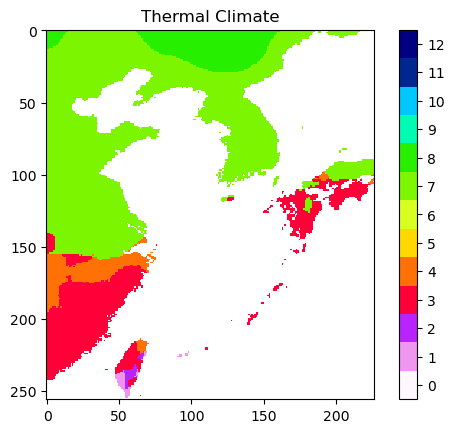

In [22]:
'''save and visualize result'''
fig = plt.figure()
ax=fig.add_subplot()

# colorbar information
bounds=np.linspace(-0.5,12.5,14)
ticks=np.linspace(0,12,13).astype('int')
cmap=plt.get_cmap('gist_ncar_r', 13)
norm=colors.BoundaryNorm(bounds,cmap.N)

plt.title('Thermal Climate')
im=ax.imshow(tclimate, cmap=cmap, norm=norm, interpolation='none')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_ThermalClimate.png",bbox_inches ="tight",dpi=300) #Save as PNG image
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_ThermalClimate.tif',tclimate) #Save as GeoTIFF raster

#### Thermal Zone
The thermal zone is classified based on actual temperature which reflects on the temperature regimes of major thermal climates

In [23]:
tzone = clim_reg.getThermalZone()

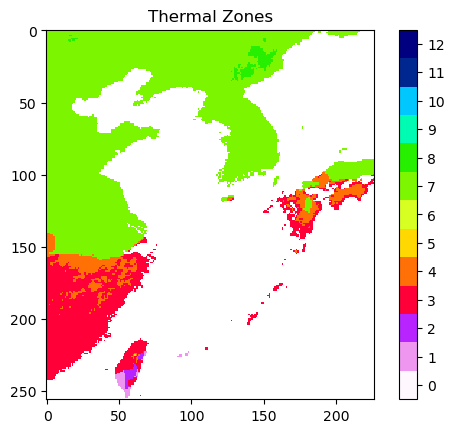

In [24]:
'''save and visualize result'''
fig = plt.figure()
ax=fig.add_subplot()

# colorbar information
bounds=np.linspace(-0.5,12.5,14)
ticks=np.linspace(0,12,13).astype('int')
cmap=plt.get_cmap('gist_ncar_r', 13)
norm=colors.BoundaryNorm(bounds,cmap.N)

plt.title('Thermal Zones')
im=ax.imshow(tzone, cmap=cmap, norm=norm, interpolation='none')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_ThermalZone.png",bbox_inches ="tight",dpi=300) #Save as PNG image
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_ThermalZone.tif',tzone) #Save as GeoTIFF raster

#### Thermal Length of Growing Period (LGP)
The thermal length of growing period (LGPt) is defined as the number of days in a year during which the daily mean temperature (Ta) is conductive to crop growth and development. PyAEZ utilizes the AEZ three standard temperature thresholds for LGPt:
- Periods with Ta>0°C (LGPt0)
- Periods with Ta>5°C (LGPt5) – the period conductive to plant growth and development
- Periods, and Ta>10°C (LGPt10) – a proxy for the period of low risks for late and early frost occurrences and termed ‘frost-free period’

In [25]:
lgpt0 = clim_reg.getThermalLGP0()
lgpt5 = clim_reg.getThermalLGP5()
lgpt10 = clim_reg.getThermalLGP10()

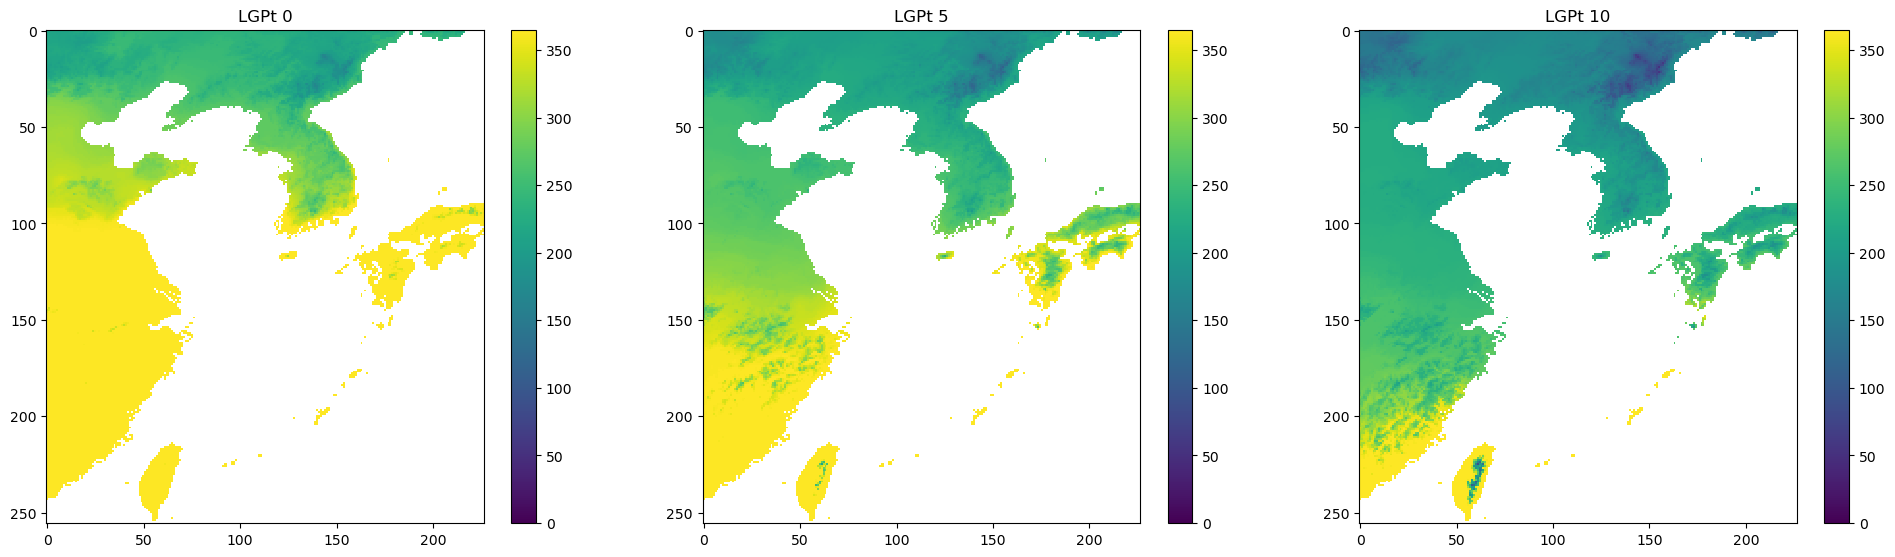

In [26]:
'''save and visualize result'''
vmin=0
vmax=365
#======================
plt.figure(1, figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(lgpt0,vmin=vmin,vmax=vmax,interpolation='none')
plt.title('LGPt 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(lgpt5, vmin=vmin, vmax=vmax,interpolation='none')
plt.title('LGPt 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(lgpt10, vmin=vmin, vmax=vmax,interpolation='none')
plt.title('LGPt 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.savefig(output_path+"ASIA_ThermalLGPs.png",bbox_inches="tight", dpi=300)
plt.show()
#======================
obj_util.saveRaster(maskfile, output_path+'ASIA_LGPt0.tif', lgpt0)
obj_util.saveRaster(maskfile, output_path+'ASIA_LGPt5.tif', lgpt5)
obj_util.saveRaster(maskfile, output_path+'ASIA_LGPt10.tif', lgpt10)

#### Temperature Sum

In [27]:
tsum0 = clim_reg.getTemperatureSum0()
tsum5 = clim_reg.getTemperatureSum5()
tsum10 = clim_reg.getTemperatureSum10()

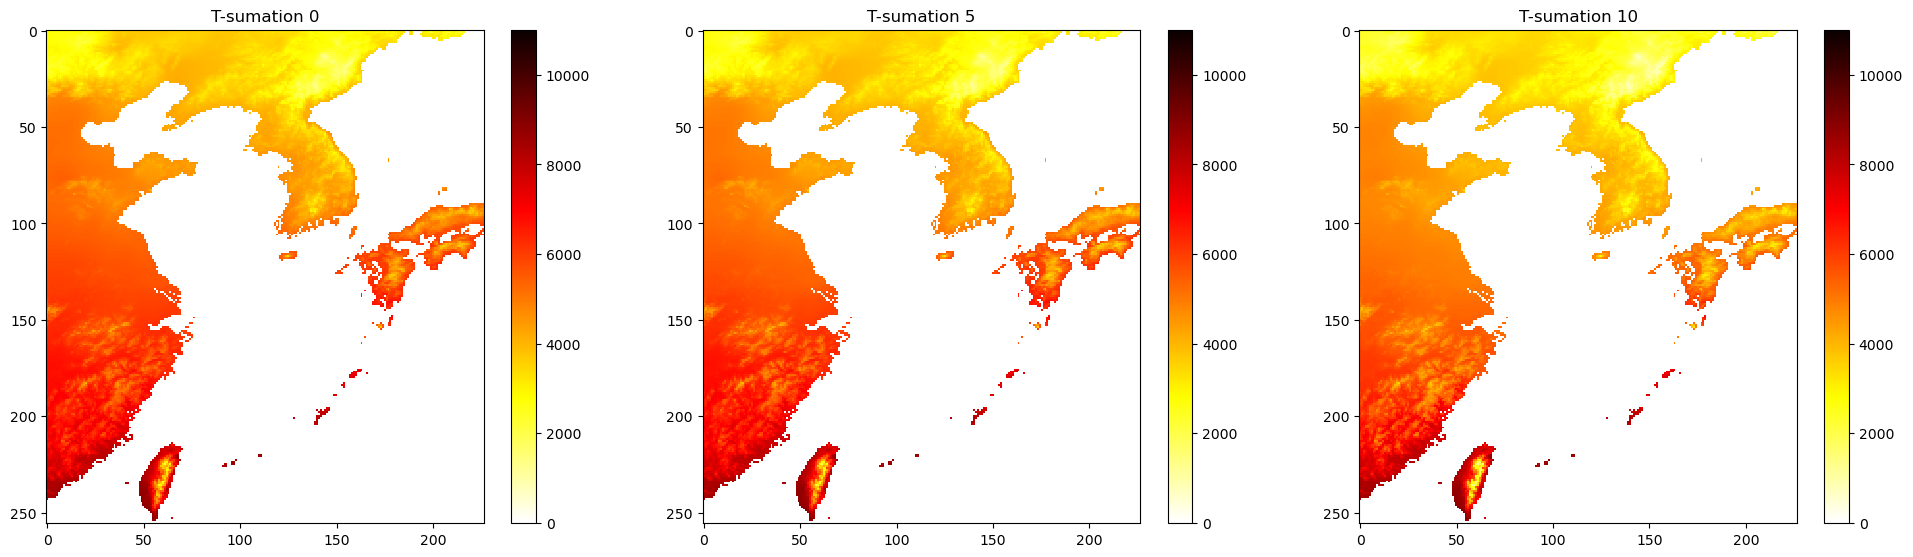

In [28]:
'''save and visualize result'''
vmin=0
vmax=11000
cmap='hot_r'
#======================
plt.figure(1, figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(tsum0, cmap=cmap,vmin=vmin, vmax=vmax,interpolation='none')
plt.title('T-sumation 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(tsum5, cmap=cmap, vmin=vmin, vmax=vmax,interpolation='none')
plt.title('T-sumation 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(tsum10, cmap=cmap, vmin=vmin, vmax=vmax,interpolation='none')
plt.title('T-sumation 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.savefig(output_path+"ASIA_Tsum.png",bbox_inches="tight", dpi=300)
plt.show()
#======================
obj_util.saveRaster(maskfile, output_path+'ASIA_tsum0.tif', tsum0)
obj_util.saveRaster(maskfile, output_path+'ASIA_tsum5.tif', tsum5)
obj_util.saveRaster(maskfile, output_path+'ASIA_tsum10.tif', tsum10)

#### Temperature Profile

In [29]:
tprofile = clim_reg.getTemperatureProfile()

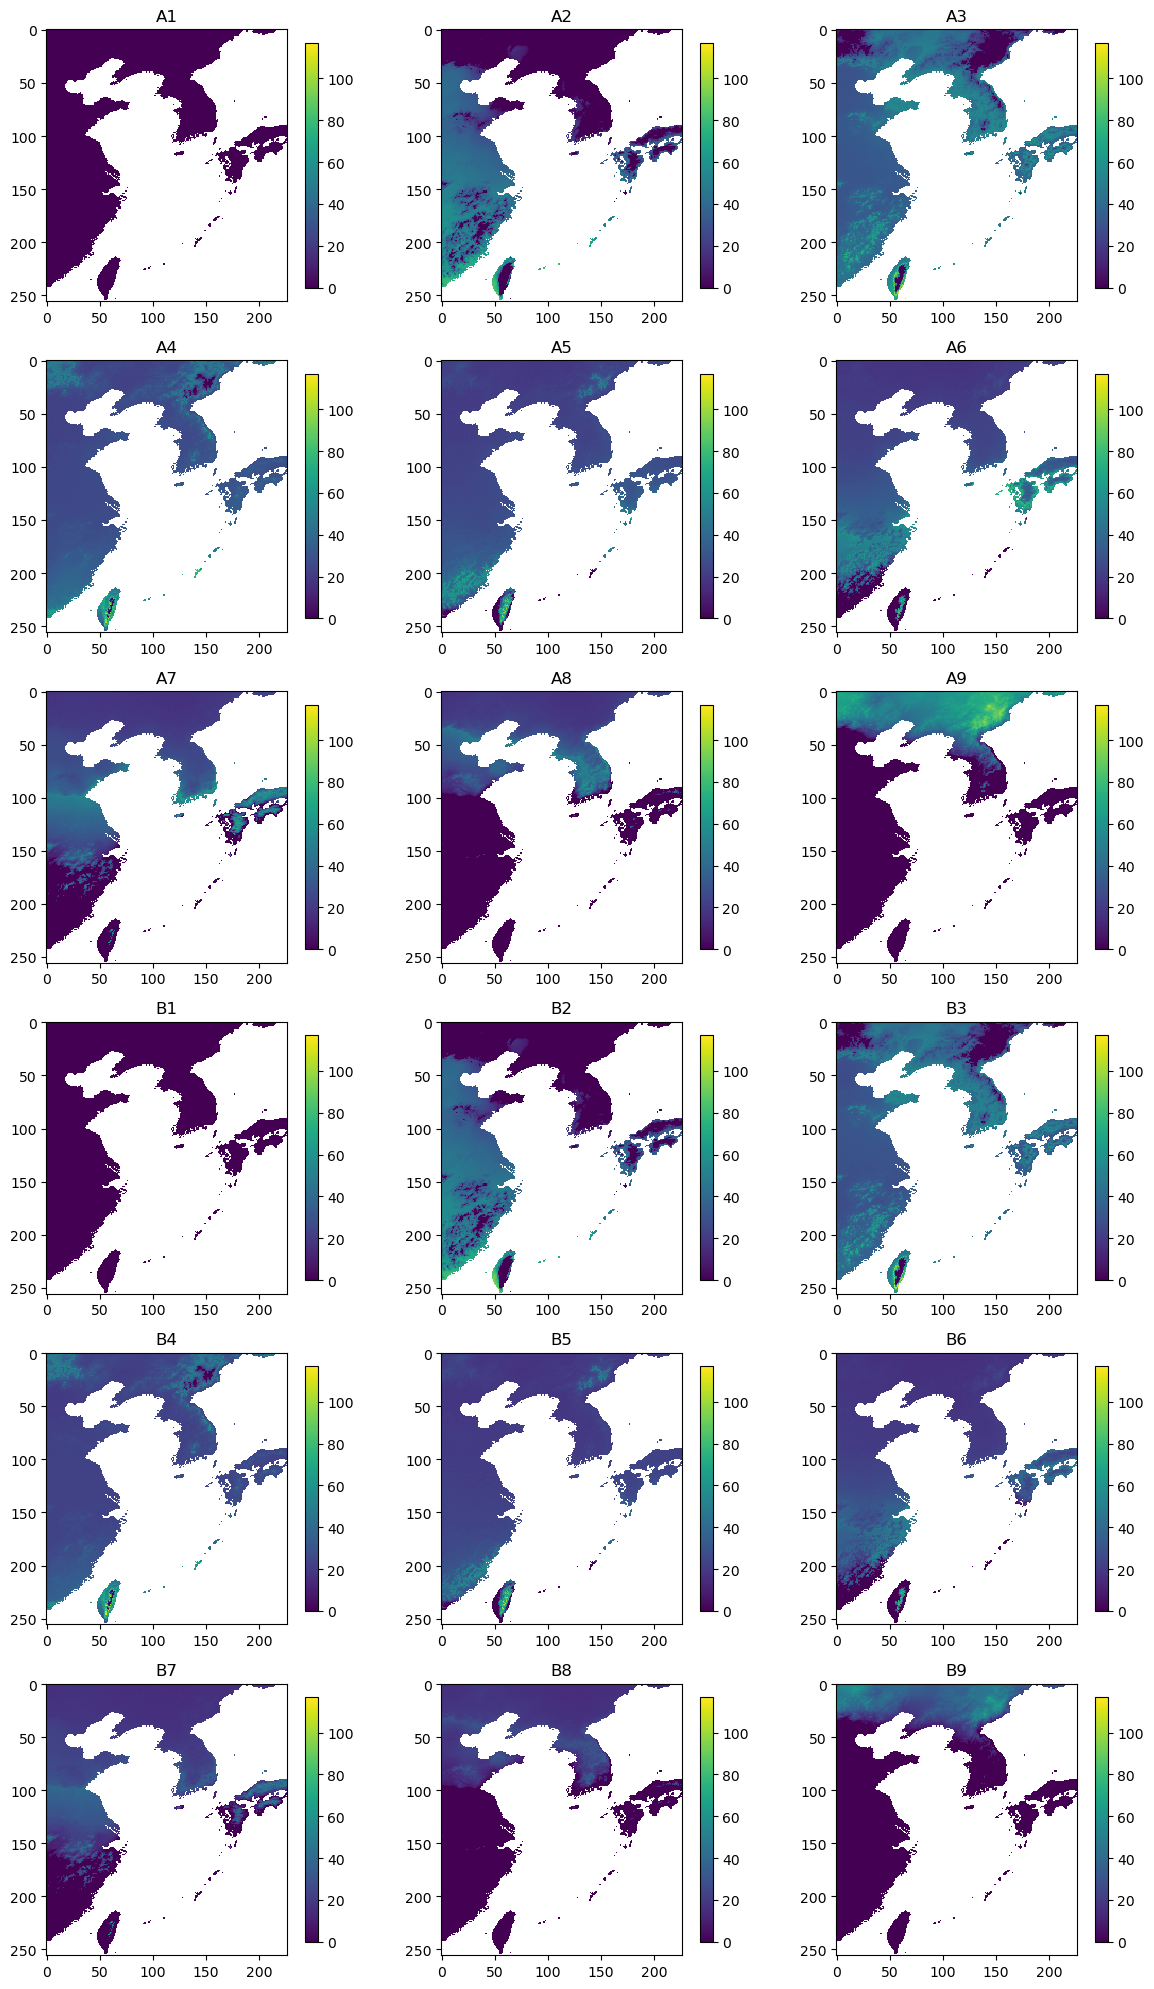

In [30]:
'''save and visualize result'''

tile_list = ['A1','A2','A3','A4','A5','A6','A7','A8','A9',
            'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

vmax=np.nanmax(tprofile)
vmin=np.nanmin(tprofile)            

fig = plt.figure(figsize=(12, 20))
for i1 in range(1, 19):
    plt.subplot(6, 3, i1)
    plt.imshow(tprofile[i1-1],interpolation='none',vmin=vmin,vmax=vmax)
    plt.title(tile_list[i1-1])
    plt.colorbar(shrink=0.9)
plt.tight_layout()

plt.savefig(output_path+"ASIA_Tprofiles.png",bbox_inches="tight", dpi=300)
plt.show()

for label,profile in zip(tile_list,tprofile):
    obj_util.saveRaster(maskfile,output_path+"TProfile_"+label+"_ASIA.tif",profile) #Save as GeoTIFF raster


#### Length of Growing Periods (LGPs)

In [31]:
lgp = clim_reg.getLGP(Sa=100., D=1.)
lgp_class = clim_reg.getLGPClassified(lgp)
lgp_equv = clim_reg.getLGPEquivalent()

using larger chunks: 5 total chunks instead of 19 for speedier calculation of LGP


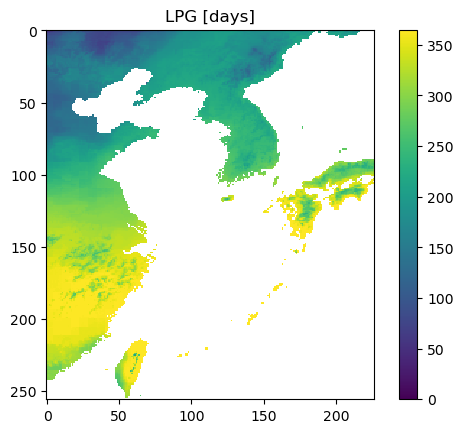

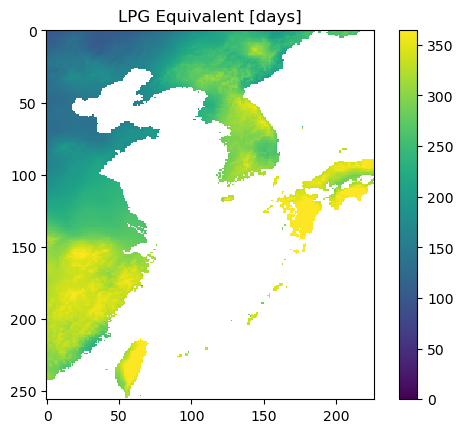

In [32]:
'''save and visualize result'''

vmin=0
vmax=365
cmap='viridis'
#======================
plt.imshow(lgp, cmap=cmap, vmin=vmin, vmax=vmax,interpolation='none')
plt.title('LPG [days]')
plt.colorbar()

plt.savefig(output_path+"ASIA_LGP.png", bbox_inches="tight", dpi=300)
plt.show()

#----------------------

plt.imshow(lgp_equv, cmap=cmap, vmin=vmin, vmax=vmax,interpolation='none')
plt.title('LPG Equivalent [days]')
plt.colorbar()

plt.savefig(output_path+"ASIA_LGP_Equv.png",bbox_inches="tight", dpi=300)
plt.show()

#----------------------

obj_util.saveRaster(maskfile, output_path+'ASIA_LGP.tif', lgp)
obj_util.saveRaster(maskfile, output_path+'ASIA_LGPEquivalent.tif', lgp_equv)


#### Multi Cropping Zone
Multiple cropping zones classification is an additional agro-climatic indicator, which relates to the possibility of cultivating multiple sequential crops under rain-fed and irrigated conditions.

In [33]:
multi_crop = clim_reg.getMultiCroppingZones(tclimate, lgp, lgpt5, lgpt10, tsum0, tsum10)
multi_crop_rainfed = multi_crop[0]  # for rainfed conditions
multi_crop_irr = multi_crop[1]  # for irrigated conditions

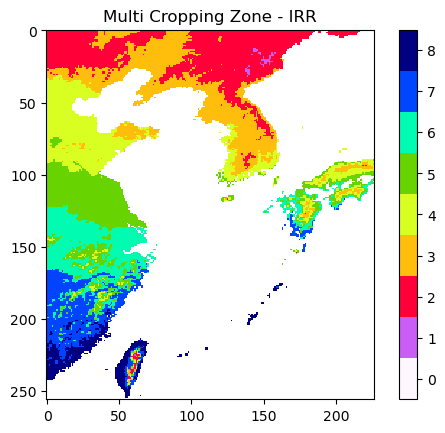

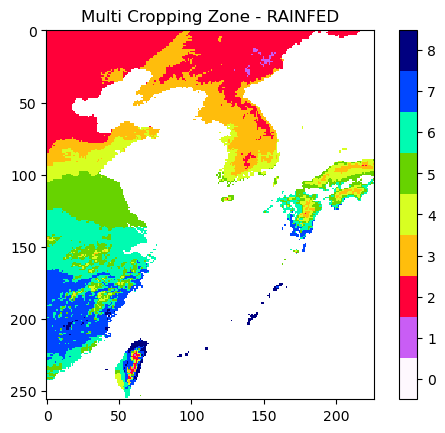

In [34]:
'''save and visualize result'''

# colorbar information
bounds=np.linspace(-0.5,8.5,10)
ticks=np.linspace(0,8,9).astype('int')
cmap=plt.get_cmap('gist_ncar_r', 9)
norm=colors.BoundaryNorm(bounds,cmap.N)

#----------------------

fig = plt.figure()
ax=fig.add_subplot()
im=ax.imshow(multi_crop_irr, cmap=cmap, norm=norm, interpolation='none')
plt.title('Multi Cropping Zone - IRR')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_multicrop_irr.png", bbox_inches="tight", dpi=300)
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_multicrop_irr.tif', multi_crop_irr)

#----------------------

fig = plt.figure()
ax=fig.add_subplot()
im=ax.imshow(multi_crop_rainfed,cmap=cmap, norm=norm,interpolation='none')
plt.title('Multi Cropping Zone - RAINFED')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_multicrop_rain.png",bbox_inches="tight", dpi=300)
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_multicrop_rain.tif', multi_crop_rainfed)


### Air Frost Index and Permafrost Evaluation
Occurrence of continuous or discontinuous permafrost conditions are used in the suitability assessment. Permafrost areas are characterized by sub-soil at or below the freezing point for two or more years. In this section, PyAEZ utilizes the air frost index (FI) which is used to characterize climate-derived permafrost condition into 4 classes: 
1) Continuous permafrost
2) Discontinuous permafrost 
3) Sporadic permafrost
4) No permafrost

In [35]:
permafrost_eval = clim_reg.AirFrostIndexandPermafrostEvaluation()
frost_index = permafrost_eval[0]
permafrost = permafrost_eval[1]

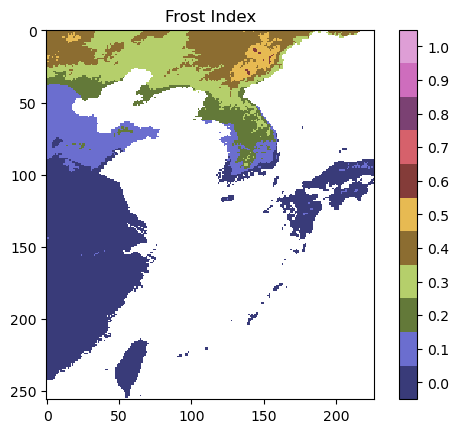

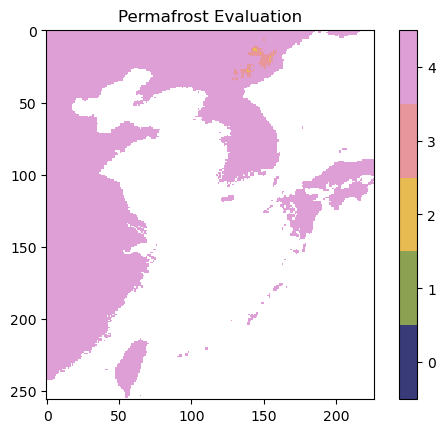

In [36]:
'''save and visualize result'''

#----------------------

# colorbar information
bounds=np.linspace(-0.05,1.05,12)
ticks=np.linspace(0,1,11)
cmap=plt.get_cmap('tab20b', 11)
norm=colors.BoundaryNorm(bounds,cmap.N)

fig = plt.figure()
ax=fig.add_subplot()
im=ax.imshow(frost_index, cmap=cmap, norm=norm, interpolation='none')
plt.title('Frost Index')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_frost_index.png",bbox_inches="tight", dpi=300)
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_frost_index.tif', frost_index)

#----------------------

# colorbar information
bounds=np.linspace(-0.5,4.5,6)
ticks=np.linspace(0,4,5)
cmap=plt.get_cmap('tab20b', 5)
norm=colors.BoundaryNorm(bounds,cmap.N)

fig = plt.figure()
ax=fig.add_subplot()
im=ax.imshow(permafrost, cmap=cmap, norm=norm,interpolation='none')
plt.title('Permafrost Evaluation')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_permafrost.png",bbox_inches="tight", dpi=300)
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_permafrost.tif', permafrost)


### Fallow period requirement
Fallow is an agricultural technique that consists of not sowing the arable land during one or more growing seasons. In AEZ framework, the fallow factors have been established by main crop groups and environmental conditions. The crop groups include cereals, legumes, roots and tubers, and a miscellaneous group consisting of long-term annuals/perennials. The fallow factors are expressed as percentage of time during the fallow-cropping cycle the land must be under fallow. PyAEZ determines the fallow requirements using Thermal Zones.

In [37]:
tzone_fallow = clim_reg.TZoneFallowRequirement(tzone)

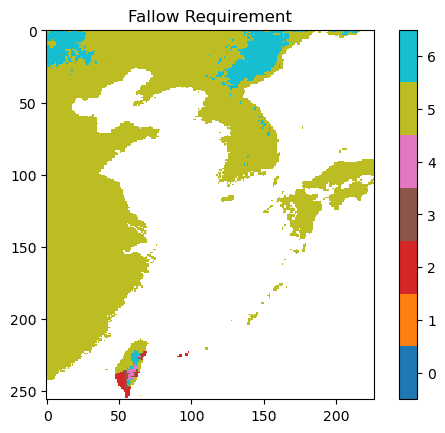

In [38]:
'''save and visualize result'''

# colorbar information
bounds=np.linspace(-0.5,6.5,8)
ticks=np.linspace(0,6,7)
cmap=plt.get_cmap('tab10', 7)
norm=colors.BoundaryNorm(bounds,cmap.N)

fig = plt.figure()
ax=fig.add_subplot()
im=ax.imshow(tzone_fallow, cmap=cmap, norm=norm,interpolation='none')
plt.title('Fallow Requirement')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_fallow.png",bbox_inches="tight", dpi=300)
plt.show()

obj_util.saveRaster(maskfile,output_path+'ASIA_fallow.tif', tzone_fallow)


### Agro-ecological zones classification
The agro-ecological zones (AEZ) methodology provides a framework for establishing a spatial inventory of land resources compiled from global/national environmental data sets and assembled to quantify multiple spatial characteristics required for the assessments of land productivity under location-specific agro-ecological conditions.

In [39]:
aez = clim_reg.AEZClassification(
    tclimate, lgp, lgp_equv, lgpt5, soil_terrain_lulc, permafrost)

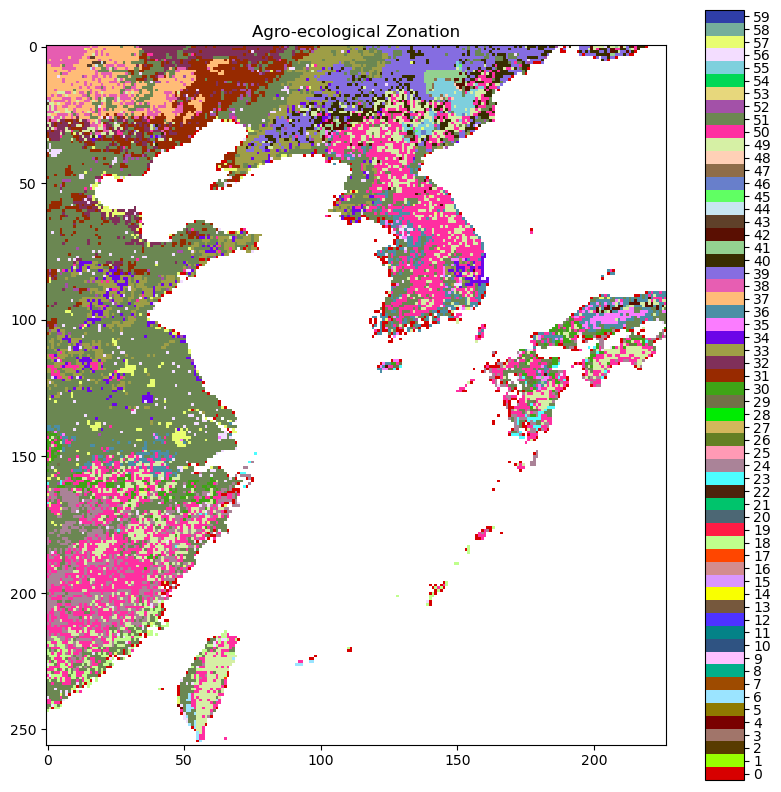

In [40]:
# colorbar information
bounds=np.linspace(-0.5,59.5,61)
ticks=np.linspace(0,59,60)
cmap=cc.cm.glasbey
norm=colors.BoundaryNorm(bounds,cmap.N)

fig = plt.figure(figsize= (10,10))
ax=fig.add_subplot()
im=ax.imshow(aez, cmap=cmap,norm=norm,interpolation='none')
plt.title('Agro-ecological Zonation')
cbar=fig.colorbar(im,ax=ax,norm=norm,ticks=ticks)
cbar.minorticks_off()

plt.savefig(output_path+"ASIA_aez.png",bbox_inches="tight", dpi=300)
plt.show()

obj_util.saveRaster(maskfile, output_path+'ASIA_aez.tif', aez)


<hr>

### END OF MODULE 1: CLIMATE REGIME

<hr>